> **Note:** This notebook contains the CNN v1 training run. For final results comparing all three CNN versions (v1→v2→v3) against the LightGBM baseline, see [`reports/06-01_cnn-model-comparison.ipynb`](../reports/06-01_cnn-model-comparison.ipynb).

# Phase 6: CNN Model

Train a CNN on rasterized 3x64x64 room images + tabular side-inputs (room type embedding, area, door position).
Compare against LightGBM baseline (test MAE=11.02, R²=0.80).

**Architecture**: 4 conv blocks (32→64→128→256) → GlobalAvgPool → concat with Embedding(9→16) + 3 scalars → FC(275→128→1)  
**Training**: MSE loss, AdamW (lr=1e-3, wd=1e-4), CosineAnnealingLR, early stopping (patience 10)  
**Augmentation**: hflip, vflip, rot90 (train only)

**Plan**: [plans/06-cnn-model.md](../plans/06-cnn-model.md) | **Baseline MAE**: 11.02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
from pathlib import Path
from torch.utils.data import DataLoader

from furnisher_surrogate.data import load_apartments, assign_splits, ROOM_TYPES
from furnisher_surrogate.models import RoomCNN
from furnisher_surrogate.train import (
    RoomDataset, train_one_epoch, evaluate,
    compute_metrics, per_type_metrics,
)

plt.rcParams.update({"figure.dpi": 120, "figure.facecolor": "white"})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
  GPU: NVIDIA GeForce RTX 4060 Laptop GPU
  VRAM: 8.6 GB


## 1. Data

In [2]:
# Load apartments and create datasets
apartments = load_apartments()

ds_train = RoomDataset(apartments, "train", augment=True)
ds_val = RoomDataset(apartments, "val",
                     area_mean=ds_train.area_mean, area_std=ds_train.area_std)
ds_test = RoomDataset(apartments, "test",
                      area_mean=ds_train.area_mean, area_std=ds_train.area_std)

print(f"Train: {len(ds_train):,} rooms")
print(f"Val:   {len(ds_val):,} rooms")
print(f"Test:  {len(ds_test):,} rooms")
print(f"Area normalization (train): mean={ds_train.area_mean:.2f}, std={ds_train.area_std:.2f}")

Train: 36,702 rooms
Val:   4,584 rooms
Test:  4,594 rooms
Area normalization (train): mean=11.81, std=7.94


In [3]:
# DataLoaders (num_workers=0 for Windows + Jupyter compatibility)
BATCH_SIZE = 128

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=0, pin_memory=True)

print(f"Batches per epoch — train: {len(train_loader)}, val: {len(val_loader)}, test: {len(test_loader)}")

Batches per epoch — train: 287, val: 36, test: 36


## 2. Model + W&B

In [4]:
# Model
model = RoomCNN().to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"RoomCNN: {n_params:,} parameters")
print(model)

# Training config
N_EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 10

config = {
    "model": "RoomCNN",
    "n_params": n_params,
    "epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "scheduler": "CosineAnnealingLR",
    "patience": PATIENCE,
    "loss": "MSE",
    "optimizer": "AdamW",
    "augmentation": "hflip+vflip+rot90",
    "channels": (32, 64, 128, 256),
    "fc_hidden": 128,
    "embed_dim": 16,
    "dropout": 0.3,
    "area_mean": ds_train.area_mean,
    "area_std": ds_train.area_std,
    "train_rooms": len(ds_train),
    "val_rooms": len(ds_val),
    "test_rooms": len(ds_test),
    "baseline_mae": 11.02,
    "device": str(device),
}

run = wandb.init(
    project="furnisher-surrogate",
    group="cnn",
    name="cnn-v1",
    config=config,
    tags=["cnn", "phase6"],
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\MartinBielik\_netrc.


RoomCNN: 424,977 parameters
RoomCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1

wandb: Currently logged in as: martin-bielik (infau) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: setting up run 3wcevehy


wandb: Tracking run with wandb version 0.25.0


wandb: Run data is saved locally in C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\notebooks\wandb\run-20260226_153404-3wcevehy
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run cnn-v1


wandb:  View project at https://wandb.ai/infau/furnisher-surrogate


wandb:  View run at https://wandb.ai/infau/furnisher-surrogate/runs/3wcevehy


## 3. Training Loop

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

model_path = Path("../models/cnn_v1.pt")
model_path.parent.mkdir(parents=True, exist_ok=True)

best_val_mae = float("inf")
best_epoch = -1
patience_counter = 0
history = {"train_loss": [], "val_loss": [], "val_mae": [], "lr": []}

for epoch in range(N_EPOCHS):
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluate on val
    y_val_true, y_val_pred, _ = evaluate(model, val_loader, device)
    val_loss = float(criterion(torch.tensor(y_val_pred), torch.tensor(y_val_true)).item())
    val_mae = float(np.mean(np.abs(y_val_true - y_val_pred)))
    current_lr = optimizer.param_groups[0]["lr"]

    # Log to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": train_loss,
        "val/loss": val_loss,
        "val/mae": val_mae,
        "lr": current_lr,
    })

    # Track history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mae"].append(val_mae)
    history["lr"].append(current_lr)

    # Early stopping on val MAE
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch = epoch
        patience_counter = 0
        # Save best checkpoint
        torch.save({
            "model_state_dict": model.state_dict(),
            "config": config,
            "area_mean": ds_train.area_mean,
            "area_std": ds_train.area_std,
            "epoch": epoch + 1,
            "val_mae": val_mae,
        }, model_path)
    else:
        patience_counter += 1

    scheduler.step()

    if (epoch + 1) % 5 == 0 or patience_counter == 0:
        marker = " *" if patience_counter == 0 else ""
        print(f"Epoch {epoch+1:>3d}/{N_EPOCHS}  "
              f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
              f"val_mae={val_mae:.2f}  lr={current_lr:.6f}{marker}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (patience={PATIENCE})")
        break

print(f"\nBest epoch: {best_epoch+1}, best val MAE: {best_val_mae:.2f}")
print(f"Model saved to {model_path}")

Epoch   1/50  train_loss=1857.5851  val_loss=1529.7653  val_mae=34.69  lr=0.001000 *


Epoch   2/50  train_loss=1495.7290  val_loss=1383.4821  val_mae=32.53  lr=0.000999 *


Epoch   3/50  train_loss=1364.1321  val_loss=1235.2974  val_mae=30.57  lr=0.000996 *


Epoch   4/50  train_loss=1181.9947  val_loss=1029.3950  val_mae=27.61  lr=0.000991 *


Epoch   5/50  train_loss=996.2219  val_loss=933.8527  val_mae=26.62  lr=0.000984 *


Epoch   6/50  train_loss=882.4667  val_loss=794.1070  val_mae=22.48  lr=0.000976 *


Epoch   7/50  train_loss=825.5539  val_loss=748.5950  val_mae=21.55  lr=0.000965 *


Epoch   8/50  train_loss=790.9487  val_loss=724.6088  val_mae=20.80  lr=0.000952 *


Epoch  10/50  train_loss=751.4097  val_loss=681.3613  val_mae=20.46  lr=0.000922 *


Epoch  11/50  train_loss=729.4801  val_loss=670.1256  val_mae=20.44  lr=0.000905 *


Epoch  12/50  train_loss=712.1218  val_loss=652.0057  val_mae=19.58  lr=0.000885 *


Epoch  15/50  train_loss=684.1251  val_loss=622.8515  val_mae=19.64  lr=0.000819


Epoch  16/50  train_loss=672.6898  val_loss=603.0679  val_mae=18.92  lr=0.000794 *


Epoch  17/50  train_loss=664.6232  val_loss=595.6339  val_mae=18.69  lr=0.000768 *


Epoch  20/50  train_loss=636.6638  val_loss=575.1596  val_mae=18.41  lr=0.000684 *


Epoch  22/50  train_loss=629.9972  val_loss=560.1982  val_mae=18.35  lr=0.000624 *


Epoch  23/50  train_loss=622.0329  val_loss=563.3517  val_mae=18.07  lr=0.000594 *


Epoch  25/50  train_loss=619.2844  val_loss=554.5032  val_mae=18.45  lr=0.000531


Epoch  29/50  train_loss=605.5536  val_loss=537.5020  val_mae=18.02  lr=0.000406 *


Epoch  30/50  train_loss=605.7732  val_loss=535.3221  val_mae=17.89  lr=0.000376 *


Epoch  31/50  train_loss=599.3721  val_loss=536.4315  val_mae=17.65  lr=0.000345 *


Epoch  35/50  train_loss=591.3274  val_loss=530.9465  val_mae=17.82  lr=0.000232


Epoch  38/50  train_loss=589.4974  val_loss=523.2935  val_mae=17.61  lr=0.000158 *


Epoch  40/50  train_loss=587.3090  val_loss=523.2474  val_mae=17.73  lr=0.000115


Epoch  43/50  train_loss=585.7072  val_loss=519.6694  val_mae=17.59  lr=0.000062 *


Epoch  45/50  train_loss=582.8418  val_loss=519.1967  val_mae=17.66  lr=0.000035


Epoch  50/50  train_loss=584.5408  val_loss=519.4839  val_mae=17.67  lr=0.000001

Best epoch: 43, best val MAE: 17.59
Model saved to ..\models\cnn_v1.pt


## 4. Test Evaluation

In [6]:
# Load best checkpoint
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded best model from epoch {checkpoint['epoch']} (val MAE={checkpoint['val_mae']:.2f})")

# Evaluate all splits
y_train_true, y_train_pred, rt_train = evaluate(model, train_loader, device)
y_val_true, y_val_pred, rt_val = evaluate(model, val_loader, device)
y_test_true, y_test_pred, rt_test = evaluate(model, test_loader, device)

train_m = compute_metrics(y_train_true, y_train_pred, "train")
val_m = compute_metrics(y_val_true, y_val_pred, "val")
test_m = compute_metrics(y_test_true, y_test_pred, "test")

# Log all scalar metrics
wandb.summary.update({**train_m, **val_m, **test_m})

# W&B: overall metrics table (compare to baseline instead of naive)
baseline_mae = config["baseline_mae"]
metrics_table = wandb.Table(
    columns=["Split", "n", "MAE", "vs Baseline", "RMSE", "R²",
             "Fail/Pass Acc", "Fail/Pass F1", "MAE (zeros)", "MAE (nonzero)"],
    data=[
        ["Train", len(y_train_true),
         round(train_m["train/mae"], 2),
         f"{train_m['train/mae'] - baseline_mae:+.2f}",
         round(train_m["train/rmse"], 2), round(train_m["train/r2"], 4),
         round(train_m["train/binary_accuracy"], 4), round(train_m["train/binary_f1"], 4),
         round(train_m["train/mae_on_zeros"], 2), round(train_m["train/mae_on_nonzero"], 2)],
        ["Val", len(y_val_true),
         round(val_m["val/mae"], 2),
         f"{val_m['val/mae'] - baseline_mae:+.2f}",
         round(val_m["val/rmse"], 2), round(val_m["val/r2"], 4),
         round(val_m["val/binary_accuracy"], 4), round(val_m["val/binary_f1"], 4),
         round(val_m["val/mae_on_zeros"], 2), round(val_m["val/mae_on_nonzero"], 2)],
        ["Test", len(y_test_true),
         round(test_m["test/mae"], 2),
         f"{test_m['test/mae'] - baseline_mae:+.2f}",
         round(test_m["test/rmse"], 2), round(test_m["test/r2"], 4),
         round(test_m["test/binary_accuracy"], 4), round(test_m["test/binary_f1"], 4),
         round(test_m["test/mae_on_zeros"], 2), round(test_m["test/mae_on_nonzero"], 2)],
        ["Baseline (ref)", len(y_test_true), baseline_mae, "—", None, None, None, None, None, None],
    ],
)
wandb.log({"overall_metrics": metrics_table}, commit=False)

# Print summary
print(f"\n{'':>8s}  {'MAE':>8s}  {'RMSE':>8s}  {'R²':>8s}  {'Fail/Pass Acc':>14s}  {'F1':>6s}")
print("-" * 60)
for name, m in [("Train", train_m), ("Val", val_m), ("Test", test_m)]:
    p = name.lower()
    print(f"{name:>8s}  {m[f'{p}/mae']:8.2f}  {m[f'{p}/rmse']:8.2f}  {m[f'{p}/r2']:8.4f}  "
          f"{m[f'{p}/binary_accuracy']:14.4f}  {m[f'{p}/binary_f1']:6.4f}")
print(f"\nBaseline MAE: {baseline_mae:.2f}")
delta = test_m["test/mae"] - baseline_mae
print(f"CNN test MAE: {test_m['test/mae']:.2f} ({delta:+.2f} vs baseline)")

Loaded best model from epoch 43 (val MAE=17.59)



               MAE      RMSE        R²   Fail/Pass Acc      F1
------------------------------------------------------------
   Train     17.82     22.91    0.7115          0.7870  0.8699
     Val     17.59     22.80    0.7032          0.8065  0.8834
    Test     17.90     23.08    0.7094          0.7815  0.8659

Baseline MAE: 11.02
CNN test MAE: 17.90 (+6.88 vs baseline)


## 5. Per-Room-Type Breakdown

In [7]:
# Hardcoded baseline per-type MAE from Phase 5
BASELINE_PER_TYPE = {
    "Bedroom": 10.29, "Living room": 18.84, "Bathroom": 3.14,
    "WC": 10.87, "Kitchen": 16.89, "Children 1": 6.61,
    "Children 2": 7.48, "Children 3": 9.48, "Children 4": 8.97,
}

test_pt = per_type_metrics(y_test_true, y_test_pred, rt_test)

# W&B table
room_type_table = wandb.Table(
    columns=["Room Type", "n", "n_zeros", "MAE", "vs Baseline", "RMSE", "R²",
             "Fail/Pass Acc", "Fail/Pass F1", "Baseline MAE"],
    data=[[rt,
           test_pt[rt]["n"], test_pt[rt]["n_zeros"],
           round(test_pt[rt]["mae"], 2),
           f"{test_pt[rt]['mae'] - BASELINE_PER_TYPE[rt]:+.2f}",
           round(test_pt[rt]["rmse"], 2), round(test_pt[rt]["r2"], 4),
           round(test_pt[rt]["binary_accuracy"], 4),
           round(test_pt[rt]["binary_f1"], 4),
           BASELINE_PER_TYPE[rt]]
          for rt in ROOM_TYPES if rt in test_pt],
)
wandb.log({"per_room_type_metrics": room_type_table}, commit=False)

# Summary keys for per-type MAE
for rt, d in test_pt.items():
    wandb.summary[f"test/mae_{rt}"] = d["mae"]

# Print
print(f"{'Room type':<15s}  {'n':>5s}  {'MAE':>7s}  {'Base':>6s}  {'Δ':>6s}  "
      f"{'RMSE':>7s}  {'R²':>7s}  {'Acc':>6s}  {'F1':>6s}")
print("-" * 80)
for rt in ROOM_TYPES:
    t = test_pt.get(rt, {})
    if t:
        delta = t["mae"] - BASELINE_PER_TYPE[rt]
        print(f"{rt:<15s}  {t['n']:>5d}  {t['mae']:>7.2f}  {BASELINE_PER_TYPE[rt]:>6.2f}  "
              f"{delta:>+6.2f}  {t['rmse']:>7.2f}  {t['r2']:>7.4f}  "
              f"{t['binary_accuracy']:>6.3f}  {t['binary_f1']:>6.3f}")

Room type            n      MAE    Base       Δ     RMSE       R²     Acc      F1
--------------------------------------------------------------------------------
Bedroom            744    13.53   10.29   +3.24    17.43   0.8378   0.796   0.858
Living room        750    22.42   18.84   +3.58    27.89   0.5668   0.763   0.865
Bathroom           833    14.26    3.14  +11.12    17.96   0.7807   0.828   0.906
WC                 429    29.42   10.87  +18.55    32.28   0.4921   0.639   0.780
Kitchen            833    21.07   16.89   +4.18    27.83   0.6305   0.762   0.843
Children 1         494    13.08    6.61   +6.47    16.24   0.8113   0.822   0.889
Children 2         286    13.34    7.48   +5.86    17.08   0.7866   0.836   0.897
Children 3         162    13.49    9.48   +4.01    16.94   0.7809   0.802   0.881
Children 4          63    13.37    8.97   +4.40    16.82   0.8062   0.825   0.884


## 6. Diagnostic Plots

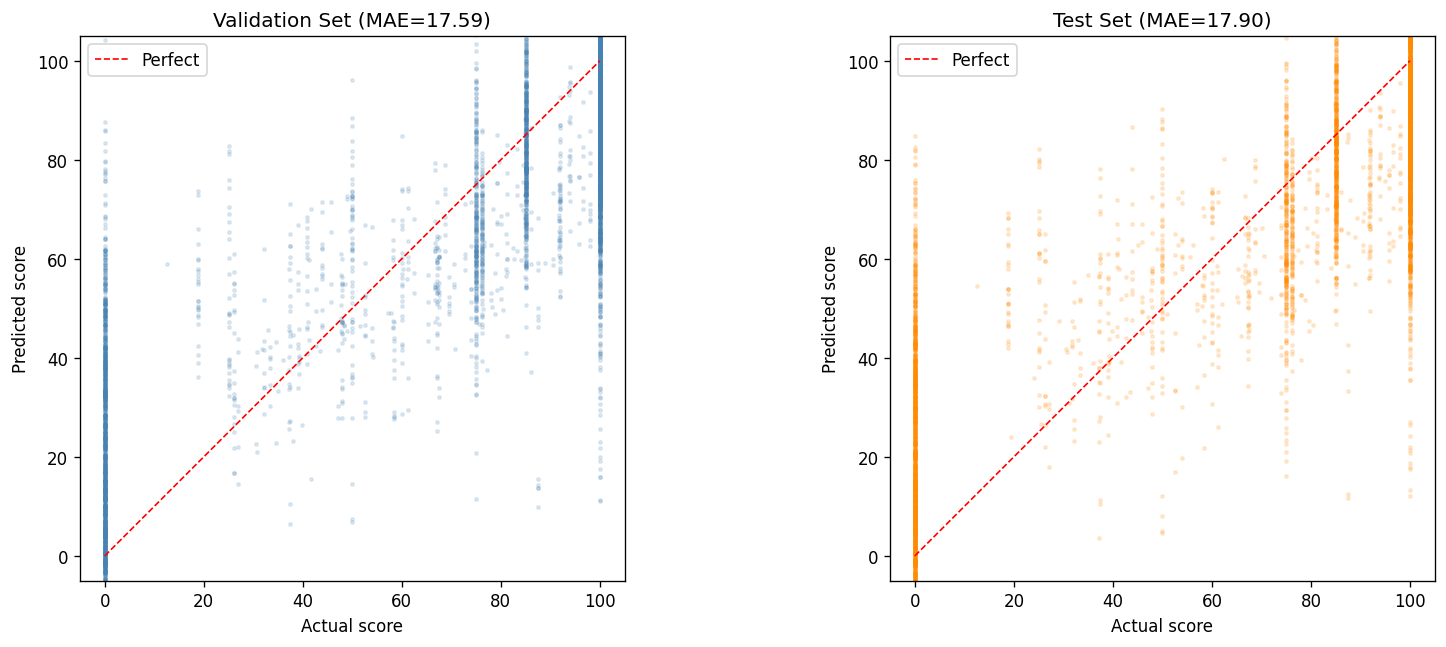

In [8]:
# Predicted vs actual scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

for ax, y_true, y_pred, label, color in [
    (axes[0], y_val_true, y_val_pred, "Validation", "steelblue"),
    (axes[1], y_test_true, y_test_pred, "Test", "darkorange"),
]:
    mae = float(np.mean(np.abs(y_true - y_pred)))
    ax.scatter(y_true, y_pred, s=4, alpha=0.15, color=color, rasterized=True)
    ax.plot([0, 100], [0, 100], "r--", linewidth=1, label="Perfect")
    ax.set_xlabel("Actual score")
    ax.set_ylabel("Predicted score")
    ax.set_title(f"{label} Set (MAE={mae:.2f})")
    ax.legend()
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.set_aspect("equal")

plt.tight_layout()
wandb.log({"plots/pred_vs_actual": wandb.Image(fig)}, commit=False)
plt.show()

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_118824\3457294699.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(type_residuals, labels=type_labels, patch_artist=True)


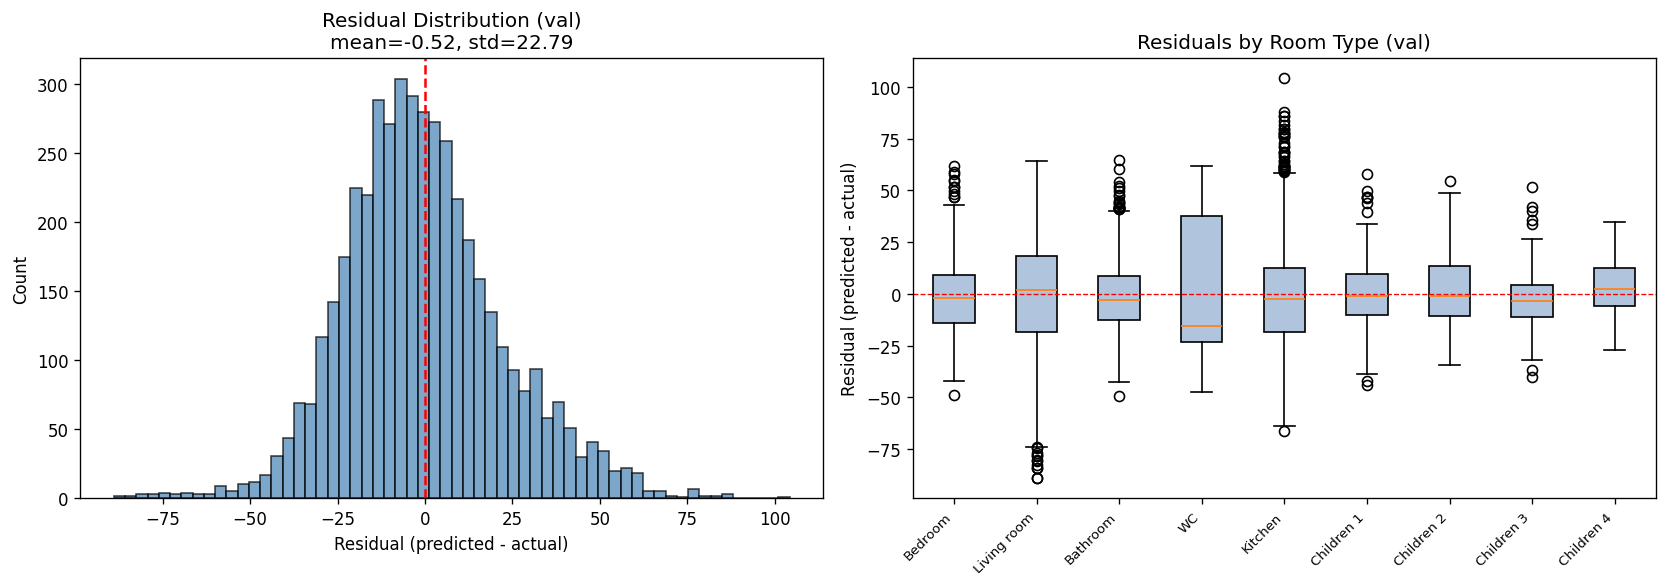

In [9]:
# Residual distribution + boxplot by room type
residuals_val = y_val_pred - y_val_true

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(residuals_val, bins=60, edgecolor="black", alpha=0.7, color="steelblue")
ax1.axvline(0, color="red", linestyle="--")
ax1.set_xlabel("Residual (predicted - actual)")
ax1.set_ylabel("Count")
ax1.set_title(f"Residual Distribution (val)\nmean={residuals_val.mean():.2f}, std={residuals_val.std():.2f}")

type_residuals = []
type_labels = []
for i, rt in enumerate(ROOM_TYPES):
    mask = rt_val == i
    if mask.any():
        type_residuals.append(residuals_val[mask])
        type_labels.append(rt)

bp = ax2.boxplot(type_residuals, labels=type_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("lightsteelblue")
ax2.set_xticklabels(type_labels, rotation=45, ha="right", fontsize=8)
ax2.axhline(0, color="red", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Residual (predicted - actual)")
ax2.set_title("Residuals by Room Type (val)")

plt.tight_layout()
wandb.log({"plots/residuals": wandb.Image(fig)}, commit=False)
plt.show()

## 7. Score Buckets

In [10]:
from sklearn.metrics import mean_absolute_error

def bucket_analysis(y_true, y_pred, label=""):
    buckets = {
        "Failed (=0)": y_true == 0,
        "Low (1-39)": (y_true >= 1) & (y_true <= 39),
        "Mid (40-69)": (y_true >= 40) & (y_true <= 69),
        "Good (70-89)": (y_true >= 70) & (y_true <= 89),
        "Excellent (90+)": y_true >= 90,
    }
    rows = []
    print(f"\n{label} — MAE by score bucket:")
    print(f"{'Bucket':<18s}  {'n':>6s}  {'%':>6s}  {'MAE':>8s}  {'Mean pred':>10s}")
    print("-" * 54)
    for name, mask in buckets.items():
        if mask.any():
            n = mask.sum()
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            mean_pred = y_pred[mask].mean()
            print(f"{name:<18s}  {n:>6d}  {n/len(y_true)*100:>5.1f}%  {mae:>8.2f}  {mean_pred:>10.2f}")
            rows.append([name, int(n), round(float(n/len(y_true)*100), 1),
                        round(mae, 2), round(float(mean_pred), 2)])
    return rows

test_rows = bucket_analysis(y_test_true, y_test_pred, "Test set")

bucket_table = wandb.Table(
    columns=["Bucket", "n", "%", "MAE", "Mean Predicted"],
    data=test_rows,
)
wandb.log({"score_bucket_analysis": bucket_table}, commit=False)


Test set — MAE by score bucket:
Bucket                   n       %       MAE   Mean pred
------------------------------------------------------
Failed (=0)           1349   29.4%     22.61       20.00
Low (1-39)             139    3.0%     21.48       47.98
Mid (40-69)            250    5.4%     12.94       55.32
Good (70-89)           952   20.7%     13.29       73.74
Excellent (90+)       1897   41.3%     17.29       88.43


## 8. CNN vs Baseline Comparison

In [11]:
# CNN vs Baseline overall comparison table
BASELINE_OVERALL = {
    "MAE": 11.02, "RMSE": 19.15, "R²": 0.8000,
    "Fail/Pass Acc": 0.8744, "Fail/Pass F1": 0.9182,
}
cnn_overall = {
    "MAE": test_m["test/mae"], "RMSE": test_m["test/rmse"], "R²": test_m["test/r2"],
    "Fail/Pass Acc": test_m["test/binary_accuracy"], "Fail/Pass F1": test_m["test/binary_f1"],
}

comparison_rows = []
for metric in BASELINE_OVERALL:
    b = BASELINE_OVERALL[metric]
    c = cnn_overall[metric]
    delta = c - b
    pct = (delta / abs(b) * 100) if b != 0 else 0
    comparison_rows.append([metric, round(b, 4), round(c, 4), round(delta, 4), f"{pct:+.1f}%"])

comparison_table = wandb.Table(
    columns=["Metric", "Baseline", "CNN", "Delta", "% Change"],
    data=comparison_rows,
)
wandb.log({"cnn_vs_baseline": comparison_table}, commit=False)

# Print
print("CNN vs Baseline (test set)")
print(f"{'Metric':<16s}  {'Baseline':>10s}  {'CNN':>10s}  {'Delta':>10s}  {'%':>8s}")
print("-" * 60)
for row in comparison_rows:
    print(f"{row[0]:<16s}  {row[1]:>10.4f}  {row[2]:>10.4f}  {row[3]:>+10.4f}  {row[4]:>8s}")

CNN vs Baseline (test set)
Metric              Baseline         CNN       Delta         %
------------------------------------------------------------
MAE                  11.0200     17.9005     +6.8805    +62.4%
RMSE                 19.1500     23.0849     +3.9349    +20.5%
R²                    0.8000      0.7094     -0.0906    -11.3%
Fail/Pass Acc         0.8744      0.7815     -0.0929    -10.6%
Fail/Pass F1          0.9182      0.8659     -0.0523     -5.7%


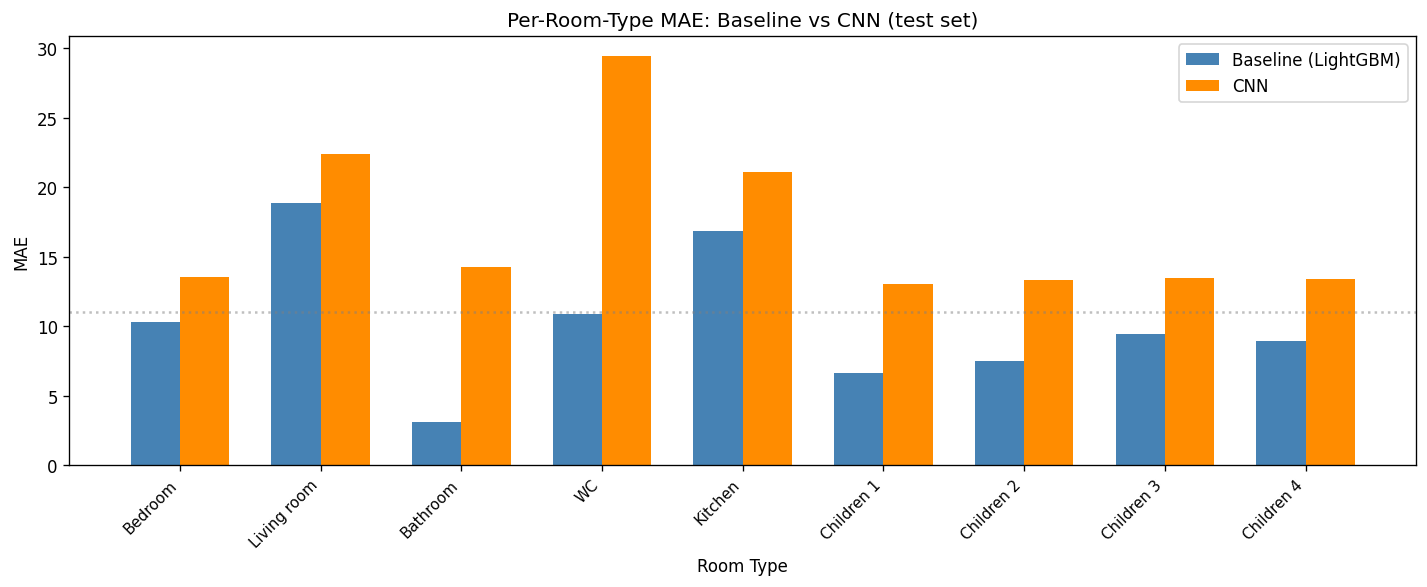

In [12]:
# Per-type comparison table + grouped bar chart
per_type_rows = []
cnn_maes = []
baseline_maes = []
rt_labels = []

for rt in ROOM_TYPES:
    if rt in test_pt:
        b = BASELINE_PER_TYPE[rt]
        c = test_pt[rt]["mae"]
        delta = c - b
        pct = (delta / b * 100) if b != 0 else 0
        per_type_rows.append([rt, round(b, 2), round(c, 2), round(delta, 2), f"{pct:+.1f}%"])
        baseline_maes.append(b)
        cnn_maes.append(c)
        rt_labels.append(rt)

per_type_table = wandb.Table(
    columns=["Room Type", "Baseline MAE", "CNN MAE", "Delta", "% Change"],
    data=per_type_rows,
)
wandb.log({"cnn_vs_baseline_per_type": per_type_table}, commit=False)

# Grouped bar chart
x = np.arange(len(rt_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, baseline_maes, width, label="Baseline (LightGBM)", color="steelblue")
bars2 = ax.bar(x + width/2, cnn_maes, width, label="CNN", color="darkorange")

ax.set_xlabel("Room Type")
ax.set_ylabel("MAE")
ax.set_title("Per-Room-Type MAE: Baseline vs CNN (test set)")
ax.set_xticks(x)
ax.set_xticklabels(rt_labels, rotation=45, ha="right", fontsize=9)
ax.legend()
ax.axhline(baseline_mae, color="gray", linestyle=":", alpha=0.5, label=f"Overall baseline ({baseline_mae})")

plt.tight_layout()
wandb.log({"plots/cnn_vs_baseline_per_type": wandb.Image(fig)}, commit=False)
plt.show()

## 9. Training Curves

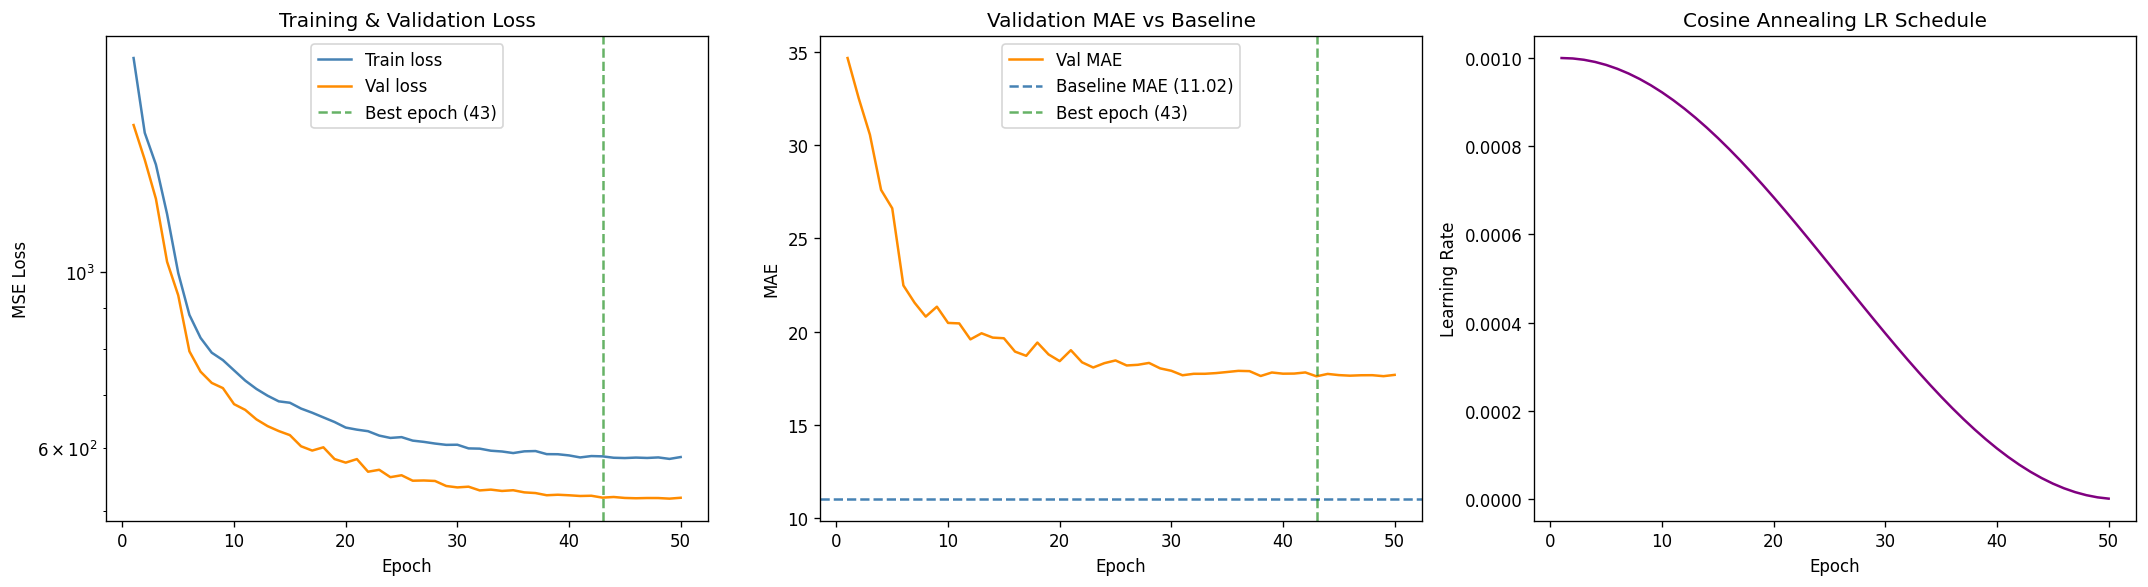

In [13]:
epochs = np.arange(1, len(history["train_loss"]) + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
ax1.plot(epochs, history["train_loss"], label="Train loss", color="steelblue")
ax1.plot(epochs, history["val_loss"], label="Val loss", color="darkorange")
ax1.axvline(best_epoch + 1, color="green", linestyle="--", alpha=0.6, label=f"Best epoch ({best_epoch+1})")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()
ax1.set_yscale("log")

# Val MAE with baseline reference
ax2.plot(epochs, history["val_mae"], label="Val MAE", color="darkorange")
ax2.axhline(baseline_mae, color="steelblue", linestyle="--", linewidth=1.5,
            label=f"Baseline MAE ({baseline_mae})")
ax2.axvline(best_epoch + 1, color="green", linestyle="--", alpha=0.6, label=f"Best epoch ({best_epoch+1})")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MAE")
ax2.set_title("Validation MAE vs Baseline")
ax2.legend()

# Learning rate schedule
ax3.plot(epochs, history["lr"], color="purple")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Learning Rate")
ax3.set_title("Cosine Annealing LR Schedule")

plt.tight_layout()
wandb.log({"plots/training_curves": wandb.Image(fig)}, commit=False)
plt.show()

## 10. Error Gallery

In [14]:
# Error gallery: worst mispredictions per room type
# We need original Room objects for rasterization — load from apartments
from furnisher_surrogate.data import get_rooms_by_split
from furnisher_surrogate.rasterize import rasterize_room
from furnisher_surrogate.features import area as compute_area, n_vertices

split_map = assign_splits(apartments)
rooms_by_split = get_rooms_by_split(apartments, split_map)
test_rooms = rooms_by_split["test"]

N_PER_DIRECTION = 10
LOW_THRESH = 30
HIGH_THRESH = 70

def room_to_wandb_image(room):
    img = rasterize_room(room)  # (3, 64, 64) uint8
    rgb = np.stack([img[0], img[1], img[2]], axis=-1)  # (64, 64, 3)
    return wandb.Image(rgb)

errors = y_test_pred - y_test_true
error_rows = []

for i_rt, rt in enumerate(ROOM_TYPES):
    mask = rt_test == i_rt
    idx_rt = np.where(mask)[0]
    y_true_rt = y_test_true[idx_rt]
    errors_rt = errors[idx_rt]

    # Overestimates: true low, predicted high
    low_mask = y_true_rt < LOW_THRESH
    low_idx = idx_rt[low_mask]
    low_errors = errors_rt[low_mask]
    top_over = low_idx[np.argsort(-low_errors)[:N_PER_DIRECTION]]

    # Underestimates: true high, predicted low
    high_mask = y_true_rt > HIGH_THRESH
    high_idx = idx_rt[high_mask]
    high_errors = errors_rt[high_mask]
    top_under = high_idx[np.argsort(high_errors)[:N_PER_DIRECTION]]

    for idx in top_over:
        room = test_rooms[idx]
        error_rows.append([
            rt, "overestimate", round(float(y_test_true[idx]), 1),
            round(float(y_test_pred[idx]), 1), round(float(errors[idx]), 1),
            round(compute_area(room), 1), n_vertices(room),
            room_to_wandb_image(room),
        ])

    for idx in top_under:
        room = test_rooms[idx]
        error_rows.append([
            rt, "underestimate", round(float(y_test_true[idx]), 1),
            round(float(y_test_pred[idx]), 1), round(float(errors[idx]), 1),
            round(compute_area(room), 1), n_vertices(room),
            room_to_wandb_image(room),
        ])

error_table = wandb.Table(
    columns=["Room Type", "Direction", "Actual", "Predicted", "Error",
             "Area (m²)", "Vertices", "Image"],
    data=error_rows,
)
wandb.log({"error_gallery": error_table}, commit=False)

n_over = sum(1 for r in error_rows if r[1] == "overestimate")
n_under = sum(1 for r in error_rows if r[1] == "underestimate")
print(f"Error gallery: {n_over} overestimates + {n_under} underestimates = {len(error_rows)} rows")

Error gallery: 90 overestimates + 90 underestimates = 180 rows


## 11. Save Checkpoint + W&B Finish

In [15]:
# Update checkpoint with test metrics
checkpoint = torch.load(model_path, map_location="cpu", weights_only=True)
checkpoint["test_mae"] = float(test_m["test/mae"])
torch.save(checkpoint, model_path)
print(f"Updated checkpoint with test_mae={checkpoint['test_mae']:.2f}")
print(f"Checkpoint contents: {list(checkpoint.keys())}")
print(f"Model file: {model_path} ({model_path.stat().st_size / 1024:.0f} KB)")

# W&B summary scalars
test_mae = test_m["test/mae"]
wandb.summary.update({
    "best_epoch": best_epoch + 1,
    "best_val_loss": best_val_mae,
    "cnn_test_mae": test_mae,
    "cnn_test_rmse": test_m["test/rmse"],
    "cnn_test_r2": test_m["test/r2"],
    "baseline_test_mae": baseline_mae,
    "improvement_over_baseline": baseline_mae - test_mae,
})

# W&B artifact
artifact = wandb.Artifact("cnn-v1", type="model",
                          description="CNN on 3x64x64 room images + tabular features")
artifact.add_file(str(model_path))
run.log_artifact(artifact)

# Run notes
best_rt = min(test_pt, key=lambda rt: test_pt[rt]["mae"])
worst_rt = max(test_pt, key=lambda rt: test_pt[rt]["mae"])
run.notes = (
    f"Phase 6 CNN: 4-block CNN on 3x64x64 rasterized rooms + tabular side-inputs. "
    f"Test MAE={test_mae:.2f} (baseline={baseline_mae}, delta={test_mae-baseline_mae:+.2f}). "
    f"R²={test_m['test/r2']:.3f}. "
    f"Best: {best_rt} ({test_pt[best_rt]['mae']:.1f}), "
    f"Worst: {worst_rt} ({test_pt[worst_rt]['mae']:.1f}). "
    f"Best epoch: {best_epoch+1}/{len(history['train_loss'])}."
)

wandb.log({}, commit=True)
wandb.finish()

print(f"\n{'='*60}")
print("PHASE 6 CNN RESULTS")
print(f"{'='*60}")
print(f"Test MAE:  {test_mae:.2f}  (baseline: {baseline_mae})")
print(f"Delta:     {test_mae - baseline_mae:+.2f}")
if test_mae < baseline_mae:
    print(f"CNN BEATS BASELINE by {baseline_mae - test_mae:.2f} points")
else:
    print(f"CNN does NOT beat baseline (baseline still better by {test_mae - baseline_mae:.2f})")
print(f"{'='*60}")

Updated checkpoint with test_mae=17.90
Checkpoint contents: ['model_state_dict', 'config', 'area_mean', 'area_std', 'epoch', 'val_mae', 'test_mae']
Model file: ..\models\cnn_v1.pt (1673 KB)


wandb: uploading artifact run-3wcevehy-error_gallery; uploading artifact cnn-v1; updating run metadata


wandb: uploading artifact run-3wcevehy-error_gallery; uploading artifact cnn-v1; uploading media\images\plots\pred_vs_actual_50_226ac36a3da3ae1659fe.png; uploading media\table\cnn_vs_baseline_50_ececb4a800178caf4ccf.table.json; uploading media\table\cnn_vs_baseline_per_type_50_c8241dfddeddc7409842.table.json (+ 5 more)


wandb: uploading artifact run-3wcevehy-error_gallery; uploading artifact cnn-v1; uploading media\images\plots\residuals_50_637fb0a92dafc3c6cdd2.png; uploading media\images\plots\training_curves_50_368d2912dd8308296eac.png


wandb: uploading artifact run-3wcevehy-error_gallery; uploading artifact cnn-v1


wandb: uploading artifact cnn-v1


wandb: uploading media\table\error_gallery_50_859778608033aff840ed.table.json; uploading wandb-summary.json; uploading config.yaml


wandb: uploading config.yaml


wandb: 
wandb: Run history:
wandb:      epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:         lr ████████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
wandb: train/loss █▇▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   val/loss █▇▆▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    val/mae █▇▆▅▅▃▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         baseline_test_mae 11.02
wandb:                best_epoch 43
wandb:             best_val_loss 17.59229
wandb:              cnn_test_mae 17.90052
wandb:               cnn_test_r2 0.70939
wandb:             cnn_test_rmse 23.08486
wandb:                     epoch 50
wandb: improvement_over_baseline -6.88052
wandb:                        lr 0.0
wandb:      test/binary_accuracy 0.78145
wandb:                       +31 ...
wandb: 


wandb:  View run cnn-v1 at: https://wandb.ai/infau/furnisher-surrogate/runs/3wcevehy
wandb:  View project at: https://wandb.ai/infau/furnisher-surrogate
wandb: Synced 4 W&B file(s), 10 media file(s), 194 artifact file(s) and 0 other file(s)


wandb: Find logs at: .\wandb\run-20260226_153404-3wcevehy\logs



PHASE 6 CNN RESULTS
Test MAE:  17.90  (baseline: 11.02)
Delta:     +6.88
CNN does NOT beat baseline (baseline still better by 6.88)
